### Competitive Agent Ensembles
In an agentic solution, each AI agent has its own biases, strengths, and weaknesses.

Using an ensemble of diverse agents mitigates the risk of a single agent producing a suboptimal or flawed response.

<p align="center">
  <img src="../../figures/competitive_ensemble.png" width="1200">
</p>

We will build an ensemble of three diverse copywriting agents tasked with creating a product description. We will then see how a judge agent can reason over their parallel outputs to select the best one, this way we get a clear improvement in the quality control process.

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

First, the strength of an ensemble comes from the diversity of its members. 

We will create three distinct copywriting “personas” using two different LLM families to maximize this diversity.

In [11]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

qwen3_llm = ChatHuggingFace(
    llm=HuggingFaceEndpoint(
        model="Qwen/Qwen3-4B-Instruct-2507"
    )
)

llama3_llm = ChatHuggingFace(
    llm=HuggingFaceEndpoint(
        model="meta-llama/Llama-3.1-8B-Instruct"
    )
)

judge_llm = ChatHuggingFace(
    llm=HuggingFaceEndpoint(
        model="moonshotai/Kimi-K2-Instruct"
    )
)


These models will have different writing styles, different knowledge cutoffs, and different inherent biases, which is exactly what we want for a robust competitive process.

In [5]:
from pydantic import BaseModel, Field
from typing import List

class ProductDescription(BaseModel):
    """A structured product description with a headline and body, the output of our copywriter agents."""
    headline: str = Field(description="A catchy, attention-grabbing headline for the product.")
    body: str = Field(description="A short paragraph (2-3 sentences) detailing the product's benefits and features.")

class FinalEvaluation(BaseModel):
    """The structured output of our Judge agent, containing the winning description and a detailed critique."""
    best_description: ProductDescription = Field(description="The winning product description chosen by the judge.")
    critique: str = Field(description="A detailed, point-by-point critique explaining why the winner was chosen over the other options, referencing the evaluation criteria.")
    winning_agent: str = Field(description="The name of the agent that produced the winning description (e.g., 'Llama3_Creative', 'Qwen3_Direct', 'Qwen3_Luxury').")

Now, let’s define the GraphState and the agent nodes. The nodes will be created using a helper function to reduce code repetition.

In [8]:
from typing import TypedDict, Annotated, Dict
from langgraph.graph.message import add_messages
from langchain_core.output_parsers import JsonOutputParser
import time

class GraphState(TypedDict):
    product_name: str
    product_category: str
    features: str
    # The dictionary will store results from the parallel competitor agents, merged with operator.update.
    competitor_results: Annotated[Dict[str, ProductDescription], lambda a, b: {**a, **b}]
    final_evaluation: FinalEvaluation
    performance_log: Annotated[List[str], add_messages]


competitor_output_parser = JsonOutputParser(
    pydantic_object=ProductDescription
)
judge_output_parser = JsonOutputParser(
    pydantic_object=FinalEvaluation
)

# A helper "factory" function to create a competitor node.
def create_competitor_node(agent_name: str, llm, prompt):
    # Each competitor is a chain: prompt -> LLM -> structured Pydantic output.
    chain = prompt | llm | competitor_output_parser
    def competitor_node(state: GraphState):
        print(f"--- [COMPETITOR: {agent_name}] Starting generation... ---")
        start_time = time.time()
        result = chain.invoke({
            "product_name": state['product_name'],
            "product_category": state['product_category'],
            "features": state['features']
        })
        execution_time = time.time() - start_time
        log = f"[{agent_name}] Completed in {execution_time:.2f}s."
        print(log)
        # The output key matches the agent's name for easy aggregation.
        return {"competitor_results": {agent_name: result}, "performance_log": [log]}
    return competitor_node

In [9]:
from langchain_core.prompts import ChatPromptTemplate

# Prompt for Agent A: Llama3, focused on creative and benefit-driven copy
llama3_creative_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a world-class copywriter known for your creative, evocative, and benefit-driven descriptions. Focus on the feeling and the 'why'.\n\n{format_instructions}"),
    ("human", "Write a product description for: {product_name}. It is a {product_category}. Key features: {features}")
]).partial(format_instructions=competitor_output_parser.get_format_instructions())

# Prompt for Agent B: Qwen 3, focused on direct, punchy, and clear copy
qwen3_direct_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an expert copywriter who values clarity and directness. Your writing is punchy, concise, and gets straight to the point. Use strong verbs.\n\n{format_instructions}"),
    ("human", "Write a product description for: {product_name}. It is a {product_category}. Key features: {features}")
]).partial(format_instructions=competitor_output_parser.get_format_instructions())

# Prompt for Agent C: Qwen 3, with a luxury brand persona
qwen3_luxury_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a copywriter for a high-end luxury brand. Your tone is sophisticated, exclusive, and aspirational. Focus on craftsmanship and the elite experience.\n\n{format_instructions}"),
    ("human", "Write a product description for: {product_name}. It is a {product_category}. Key features: {features}")
]).partial(format_instructions=competitor_output_parser.get_format_instructions())

# Prompt for the Judge Agent
judge_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are the Head of Marketing, a discerning judge of copy. Evaluate the following product descriptions based on three criteria: 1. Creativity, 2. Clarity, and 3. Impact. Provide a detailed critique and select the single best one.\n\n{format_instructions}"),
    ("human", "Product: {product_name}.\n\nHere are the descriptions to evaluate:\n\n{descriptions_to_evaluate}\n\nPlease provide your final evaluation.")
]).partial(format_instructions=judge_output_parser.get_format_instructions())

In [10]:
# Create the three competitor nodes using our factory.
# Each gets a different combination of model and prompt to ensure diversity.
llama3_creative_node = create_competitor_node("Llama3_Creative", llama3_llm, llama3_creative_prompt)
qwen3_direct_node = create_competitor_node("Qwen3_Direct", qwen3_llm, qwen3_direct_prompt)
qwen3_luxury_node = create_competitor_node("Qwen3_Luxury", qwen3_llm, qwen3_luxury_prompt)

In [16]:
# The Judge Node
def judge_node(state: GraphState):
    """Evaluates all competitor results and selects a winner."""
    print("--- [JUDGE] Evaluating competing descriptions... ---")
    start_time = time.time()
    
    descriptions_to_evaluate = ""
    for name, desc in state['competitor_results'].items():
        descriptions_to_evaluate += f"--- Option from {name} ---\nHeadline: {desc["headline"]}\nBody: {desc["body"]}\n\n"
    
    judge_chain = judge_prompt | judge_llm | judge_output_parser
    evaluation = judge_chain.invoke({
        "product_name": state['product_name'],
        "descriptions_to_evaluate": descriptions_to_evaluate
    })
    
    execution_time = time.time() - start_time
    log = f"[Judge] Completed evaluation in {execution_time:.2f}s."
    print(log)
    
    return {"final_evaluation": evaluation, "performance_log": [log]}

### Assembling the Graph
The graph structure is a classic "fan-out, fan-in" where the entry point fans out to all three competitor nodes, which run in parallel. After they all complete, the flow converges on the judge node.

In [17]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(GraphState)

# Add the competitor nodes
workflow.add_node("llama3_creative", llama3_creative_node)
workflow.add_node("qwen3_direct", qwen3_direct_node)
workflow.add_node("qwen3_luxury", qwen3_luxury_node)

# Add the judge node
workflow.add_node("judge", judge_node)

# The entry point fans out to all three competitors
workflow.set_entry_point("llama3_creative")
workflow.set_entry_point("qwen3_direct")
workflow.set_entry_point("qwen3_luxury")

# After the competitors finish, their results converge to the judge
workflow.add_edge("llama3_creative", "judge")
workflow.add_edge("qwen3_direct", "judge")
workflow.add_edge("qwen3_luxury", "judge")

# The judge's decision is the final step
workflow.add_edge("judge", END)

app = workflow.compile()

print("Graph constructed and compiled successfully.")
print("The competitive ensemble is ready for the creative showdown.")

Graph constructed and compiled successfully.
The competitive ensemble is ready for the creative showdown.


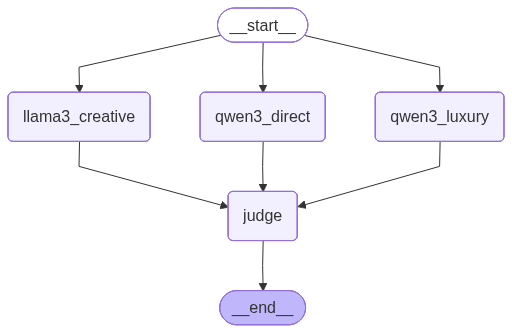

In [18]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

#### Running the Ensemble and Analyzing the Competition
Let's give our ensemble a product and observe the parallel generation and subsequent evaluation.

In [19]:
inputs = {
    "product_name": "Aura Smart Ring",
    "product_category": "Wearable Technology",
    "features": "Sleep tracking, heart rate monitoring, activity goals, titanium body, 7-day battery life",
    "performance_log": []
}

step_counter = 1
final_state = None

for output in app.stream(inputs, stream_mode="values"):
    node_name = list(output.keys())[0]
    print(f"\n{'*' * 100}")
    if step_counter == 1:
        print("**Step 1: Competitor Panel Execution (Parallel)**")
    else:
        print(f"**Step {step_counter}: {node_name.replace('_', ' ').title()} Node Execution**")
    print(f"{'*' * 100}")
    
    if step_counter == 1: # The first output is an aggregation
        final_state = output
    else:
        final_state = output[node_name]
    
    print(f"\n{'-' * 100}")
    print("Analysis:")
    if step_counter == 1:
        print("The parallel generation step is complete. All three agents started at the same time. The total time for this stage was dictated by the slowest agent. A sequential process would have taken much longer. The state will now contain three diverse product descriptions ready for judging.")
    else:
        print("The Judge agent has received the three competing descriptions, performed its evaluation based on the provided rubric, and produced a final, structured decision. The workflow is now complete.")
    print(f"{'-' * 100}")
    step_counter += 1


****************************************************************************************************
**Step 1: Competitor Panel Execution (Parallel)**
****************************************************************************************************

----------------------------------------------------------------------------------------------------
Analysis:
The parallel generation step is complete. All three agents started at the same time. The total time for this stage was dictated by the slowest agent. A sequential process would have taken much longer. The state will now contain three diverse product descriptions ready for judging.
----------------------------------------------------------------------------------------------------
--- [COMPETITOR: Llama3_Creative] Starting generation... ---
--- [COMPETITOR: Qwen3_Luxury] Starting generation... ---
--- [COMPETITOR: Qwen3_Direct] Starting generation... ---
[Qwen3_Luxury] Completed in 1.94s.
[Llama3_Creative] Completed in 2.26s.
[Q

In [22]:
output

{'product_name': 'Aura Smart Ring',
 'product_category': 'Wearable Technology',
 'features': 'Sleep tracking, heart rate monitoring, activity goals, titanium body, 7-day battery life',
 'competitor_results': {'Llama3_Creative': {'headline': 'Unlock Your Potential with Aura: The Revolutionary Smart Ring',
   'body': "Imagine a life where you're always in tune with your body and mind. With Aura Smart Ring, you can track your sleep, monitor your heart rate, and crush your daily activity goals. Crafted from durable titanium, this sleek ring is designed to keep up with your active lifestyle, while its 7-day battery life means you can wear it anywhere, anytime. Say goodbye to distractions and hello to a more intuitive you – get in sync with Aura."},
  'Qwen3_Direct': {'headline': 'Aura Smart Ring: Track Your Health, Stay Awake to Your Goals',
   'body': 'Stay in control of your wellness with the Aura Smart Ring — a sleek, lightweight wearable that monitors your sleep and heart rate in real t

In [24]:
import json

print("="*60)
print("            THE COMPETING PRODUCT DESCRIPTIONS")
print("="*60)


for name, desc in output['competitor_results'].items():
    print(f"\n--- [{name}] ---")
    print(f"Headline: {desc['headline']}")
    print(f"Body: {desc['body']}")
print("\n" + "="*60)
print("                  THE JUDGE'S FINAL VERDICT")
print("="*60)
final_eval = output['final_evaluation']
print(f"\nWinning Agent: {final_eval['winning_agent']}\n")
print("Winning Description:")
print(f"  - Headline: {final_eval['best_description']['headline']}")
print(f"  - Body: {final_eval['best_description']['body']}\n")
print("Judge's Critique:")
print(final_eval['critique'])
print("\n" + "-"*60)

            THE COMPETING PRODUCT DESCRIPTIONS

--- [Llama3_Creative] ---
Headline: Unlock Your Potential with Aura: The Revolutionary Smart Ring
Body: Imagine a life where you're always in tune with your body and mind. With Aura Smart Ring, you can track your sleep, monitor your heart rate, and crush your daily activity goals. Crafted from durable titanium, this sleek ring is designed to keep up with your active lifestyle, while its 7-day battery life means you can wear it anywhere, anytime. Say goodbye to distractions and hello to a more intuitive you – get in sync with Aura.

--- [Qwen3_Direct] ---
Headline: Aura Smart Ring: Track Your Health, Stay Awake to Your Goals
Body: Stay in control of your wellness with the Aura Smart Ring — a sleek, lightweight wearable that monitors your sleep and heart rate in real time. Set activity goals, track daily progress, and get smart insights to stay motivated. Crafted with a durable titanium body, it’s comfortable all day long. With a 7-day batt